In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasbonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()

Porcentaje de operaciones con needs_m_check: 52.31 %
Porcentaje de operaciones con moderada: 67.80 %


,created_at,moderada,stat_cr,stat_fe,amount,fee,recovery_status,user_id,id_cr,category,money_back,GBP_EUR,inflation,BTC_GBP,unemploy_rate,created_at_slot,created_at_dow,transfer_type,charge_moment
0,1.574172e+09,1,2,5,1.0,0.0,4,47,3,0,0,1.16935,1.3,6347.577148,3.9,7,1,0,0


,created_at,moderada,stat_cr,stat_fe,amount,fee,recovery_status,user_id,id_cr,category,money_back,GBP_EUR,inflation,BTC_GBP,unemploy_rate,created_at_slot,created_at_dow,transfer_type,charge_moment
0,-4.502284,0.689217,-4.167232,1.098882,-3.185956,-1.38109,0.527923,-0.296422,-1.863397,-1.344647,-1.737392,0.641888,2.324022,-1.966732,-2.926786,-0.995137,-0.95647,-1.243453,-1.289237


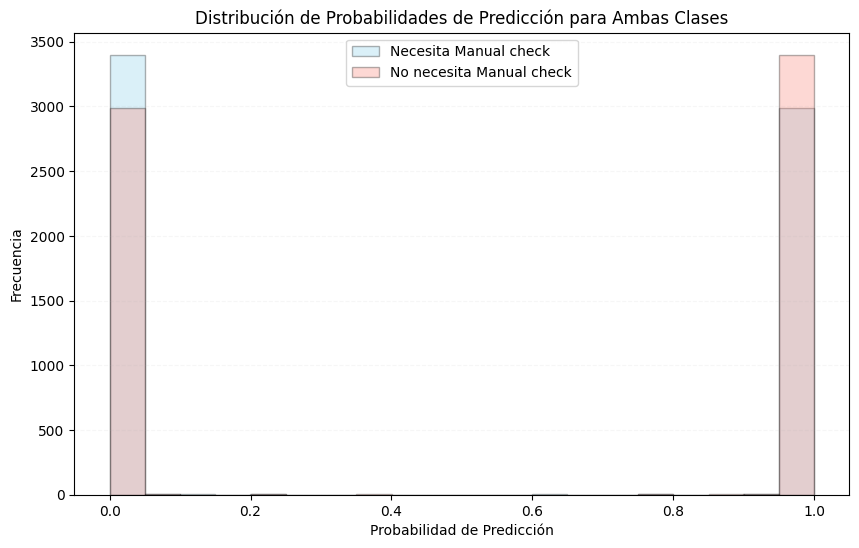

Coeficientes del modelo de regresión logística (ordenados por magnitud):
recovery_status: -7.5937
stat_fe: -7.4752
money_back: -3.9852
category: -2.1148
fee: -1.7809
stat_cr: 1.5930
id_cr: -1.2451
unemploy_rate: 0.6645
charge_moment: -0.5139
user_id: 0.4317
amount: -0.3134
moderada: -0.2781
BTC_GBP: -0.2279
created_at: 0.2206
inflation: -0.0895
transfer_type: -0.0839
GBP_EUR: -0.0797
created_at_slot: 0.0508
created_at_dow: -0.0250


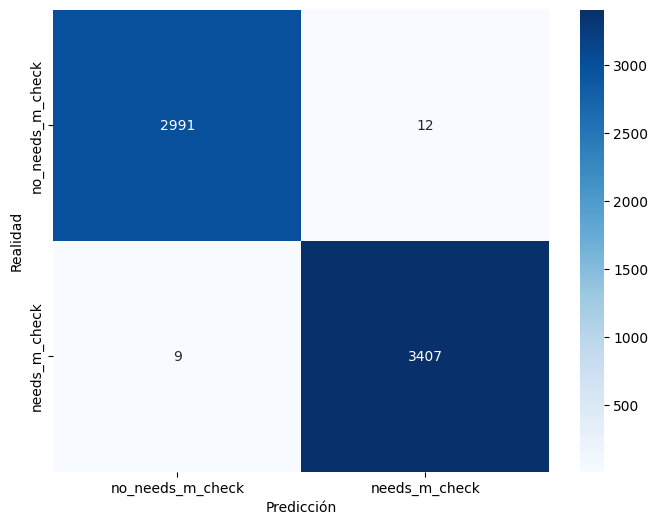

Accuracy: 0.9967284623773174
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3003
           1       1.00      1.00      1.00      3416

    accuracy                           1.00      6419
   macro avg       1.00      1.00      1.00      6419
weighted avg       1.00      1.00      1.00      6419



In [7]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

# Convertir columnas slot en enteros
df['created_at_slot'] = pd.to_numeric(df['created_at_slot'], errors='coerce').astype('Int64')
df['created_at_dow'] = pd.to_numeric(df['created_at_dow'], errors='coerce').astype('Int64')

# Preprocesamiento: Convertir variables categóricas a dummies
#X = pd.get_dummies(X, columns=['transfer_type', 'stat_cr', 'recovery_status'], drop_first=True)

# Crear una columna binaria para 'moderated_at'
#df['moderated'] = df['moderated_at'].notnull().astype(int)
df['moderada'] = df['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

df['transfer_type'] = df['transfer_type'].map({'regular': 0, 'instant': 1})
#a = df['type'].fillna('null').astype(str).unique(); print(sorted(a))
df['type'] = df['type'].fillna('null').map({
    'incident': 3, 'instant_payment': 1, 'postpone': 4, '0' : 0})

df['money_back'] = df['money_back_date'].apply(lambda x: 1 if not pd.isnull(x) else 0) 
#a = df['recovery_status'].unique(); print(sorted(a))
df['recovery_status'] = df['recovery_status'].fillna('null').map({
     'cancelled' :0 , 'completed' :1 , 'nice' :4 , 'pending': 2, 'pending_direct_debit': 3, 'null' : -1 })
#a = df['stat_cr'].unique(); print(sorted(a))
df['stat_cr'] = df['stat_cr'].fillna('null').map({
    'active': 1, 'canceled': 2, 'direct_debit_rejected': 3, 'direct_debit_sent': 4, 'money_back': 5, 'rejected': 6, 'transaction_declined': 7, 'null' : 0 })
#a = df['stat_fe'].unique(); print(sorted(a))
df['stat_fe'] = df['stat_fe'].fillna('null').map({
     'accepted': 4, 'cancelled': 3, 'confirmed': 1, 'cr_regular': 5, 'rejected': 2,     'null' : 0})
#a = df['charge_moment'].fillna('null').unique(); print(sorted(a))
df['charge_moment'] = df['charge_moment'].fillna('null').map({
    'before': 1,     'after': 2,     'null': 0 }) # Asigna 0 para los valores nulos llenados como 'null'
#a = df['category'].fillna('null').unique(); print(sorted(a))
df['category'] = df['category'].fillna('null').map({
    'month_delay_on_payment': 2, 'nice': 2, 'rejected_direct_debit': 1, 'null':0})


# TODO 2024-12-09 Alba, Cesc: ejemplo para ver el balanceo de los datos ??
# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
#value_counts = df_simpl['needs_m_check_recov'].value_counts()
value_counts = df_jo['needs_m_check_recov'].value_counts()
# Calcular el total de operaciones (suma de las dos categorías)
total = value_counts[0] + value_counts[1]
# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual = (value_counts[1] / total) * 100
# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check: {needs_manual:.2f} %')

# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts = df['moderada'].value_counts()
# Calcular el total de operaciones (suma de las dos categorías)
total = value_counts[0] + value_counts[1]
# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
moderadas = (value_counts[1] / total) * 100
# Imprimir el resultado
print(f'Porcentaje de operaciones con moderada: {moderadas:.2f} %')


columnas = ['created_at','moderada',
            'stat_cr','stat_fe','amount','fee','recovery_status', 
            'user_id', 'id_cr',
            'category', 'money_back', #'money_back_date',
            'GBP_EUR','inflation','BTC_GBP','unemploy_rate',
            'created_at_slot','created_at_dow','transfer_type','charge_moment']

y = df['needs_m_check_recov'].copy()  #moderada # La columna de la variable objetivo
df = df[columnas]
display(df.head(1))
# Crear el escalador
scaler = StandardScaler()
# Estandarizar todas las columnas
normalizado = scaler.fit_transform(df)
# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
df = pd.DataFrame(normalizado, columns=df.columns, index=df.index)
df.fillna(0, inplace=True)
X = df[columnas].copy()
#df.info()
display(df.head(1))

feature_names = X.columns # Obtener los nombres de las características
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train) # Entrena el clasificador
predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report   